# MLPS - Mercari Price ML

In [51]:
import pandas as pd 
import json 
import numpy as np
import operator
from scipy.sparse import load_npz, save_npz
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.porter import *
import string

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')  # prettier plots

### Perform data cleaning

In [33]:
data = pd.read_csv("Data/train.tsv", delimiter="\t", index_col=0)

# remove items with out a price
data = data[pd.notna(data["price"])]

data["item_description"] = data["item_description"].replace("No description yet", "")
data["item_description"] = data["item_description"].replace(np.nan, "")

temp = data["category_name"].fillna('').str.split('/')
              
data["category_name_1"] = temp.str[0]
data["category_name_2"] = temp.str[1]
data["category_name_3"] = temp.str[2:].str.join("/")

C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Implement porter stemming in count vectorizer

In [34]:
class StemmerTokenizer(object):
    def __init__(self):
        self.ps = PorterStemmer()
        self.translator = str.maketrans('', '', string.punctuation + string.digits)
        self.ps_dict = dict()
    def __call__(self, doc):
        output = []
        for w in doc.encode('ascii', errors='ignore').decode('ascii').translate(self.translator).split():
            stem = self.ps.stem(w)
            self.ps_dict.setdefault(stem,set()).add(w)
            output.append(stem)
        return output

stemmer = StemmerTokenizer()
    
vectorizer = CountVectorizer(lowercase = True,
                             max_df = .5,
                             min_df = .001,
                             tokenizer = stemmer,
                             stop_words='english')

### Count vectorize the data

In [35]:
%%time
tfm = vectorizer.fit_transform(data["item_description"])

Wall time: 16min 53s


In [36]:
%%time
tfidf_vectorizer = TfidfTransformer()
tfidf_transformed = tfidf_vectorizer.fit_transform(tfm)

Wall time: 935 ms


### For saving results

In [37]:
save_npz("tfm.npz", tfm)
save_npz("tfidf_transformed.npz", tfidf_transformed)

In [38]:
with open("vocabulary.txt", "w") as f:
    f.write("".join([k + '\n' for k, v in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]))

In [39]:
with open("porter_dictionary.json", "w") as f:
    f.write(json.dumps({k: list(v) for k, v in stemmer.ps_dict.items()}))

### For loading the data

In [4]:
tfm = load_npz("tfm.npz")
tfidf_transformed = load_npz("tfidf_transformed.npz")

In [30]:
with open("vocabulary.txt", 'r') as f:
    vocabulary = f.read().split('\n')

In [28]:
with open("porter_dictionary.json", 'r') as f:
    ps_dict = json.loads(f.read())

### Analysis Plots on Stemming Process

In [139]:
tuples = [(k, len(v)) for k, v in stemmer.ps_dict.items()]
freq = {}
for k, v in sorted(tuples, key=operator.itemgetter(1), reverse=True):
    if k in vocabulary:
        if (v in freq.keys()):
            freq[v] += 1
        else:
            freq[v] = 1
    
x, y = zip(*freq.items())

print(np.dot(x, y))

x = np.array(x)
y = np.array(y)
cum = ((x*y) - y).cumsum()

7199
7199


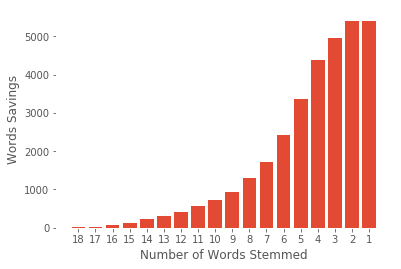

In [141]:
plt.bar(x, cum)

ax = plt.gca()
ax.invert_xaxis()
ax.set_facecolor('white')
plt.xlabel("Number of Words Stemmed")
plt.ylabel("Words Savings")
plt.xticks(x)
plt.grid(False)

In [150]:
for i in data["item_description"]:
    if (" k ") in i:
        print(i)

Colors Dolce K Poise k Smile
Kim k style dress. Super sexy on.
The limited edition bedazzled candy k matte lipstick Authentic
❤️100% brand new（never used） ❤️[rm] for 2 （ bundle ） 29 for 4 1.kourt k 2.so cute 3.candy k 4.exposed 5.koko k 6.pumpkin 7.22 8.spice 9.skylie 10.love bite ❤️buy and tell me which ones
On hand! Sold out in minutes of release. THIS WAS THE LAST RESTOCK All Unused Authentic Contains: 6 Mini Matte Liquid Lipstick (6 X 0.02 fl oz./oz. liq / 0.65 ml) Tags: kyliner kyshadow Leo exposed Koko candy k Kristen maliboo ginger bundle liner cream shadow Does not come with the box Each matte liquid lipstick mini kit contains the following shades: Exposed (warm mid-tone beige), Dolce K (deep beige nude), Koko K (pale pink), Candy K (warm pinky nude), Kristen (warm brown berry) and Leo (true deep burgundy).
A pair of wonderful 925 silver and cubic zirconia hip hop stud earrings. These fine earrings feature ecellent quality cubic zirconia set in micro pave setting design with gr